# Collaboration and Competition

---

CAPSTONE 3: UDACITY DEEP REINFORCEMENT LEARNING NANODEGREE:

SWASTIK NATH

---

### 1. Start the Environment

Run the next code cell to install a few packages.  This line will take a few minutes to run!

In [1]:
!pip -q install ./python

tensorflow 1.7.1 has requirement numpy>=1.13.3, but you'll have numpy 1.12.1 which is incompatible.
ipython 6.5.0 has requirement prompt-toolkit<2.0.0,>=1.0.15, but you'll have prompt-toolkit 3.0.5 which is incompatible.


The environment is already saved in the Workspace and can be accessed at the file path provided below. 

In [2]:
from unityagents import UnityEnvironment
import numpy as np

env = UnityEnvironment(file_name="/data/Tennis_Linux_NoVis/Tennis")

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: TennisBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 8
        Number of stacked Vector Observation: 3
        Vector Action space type: continuous
        Vector Action space size (per agent): 2
        Vector Action descriptions: , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [3]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Examine the State and Action Spaces

Run the code cell below to print some information about the environment.

In [4]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents 
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

Number of agents: 2
Size of each action: 2
There are 2 agents. Each observes a state with length: 24
The state for the first agent looks like: [ 0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.          0.         -6.65278625 -1.5        -0.          0.
  6.83172083  6.         -0.          0.        ]


### 3. Take Random Actions in the Environment

In the next code cell, you will learn how to use the Python API to control the agent and receive feedback from the environment.

Note that **in this coding environment, you will not be able to watch the agents while they are training**, and you should set `train_mode=True` to restart the environment.

In [6]:
for i in range(5):                                         # play game for 5 episodes
    env_info = env.reset(train_mode=False)[brain_name]     # reset the environment    
    states = env_info.vector_observations                  # get the current state (for each agent)
    scores = np.zeros(num_agents)                          # initialize the score (for each agent)
    while True:
        actions = np.random.randn(num_agents, action_size) # select an action (for each agent)
        actions = np.clip(actions, -1, 1)                  # all actions between -1 and 1
        env_info = env.step(actions)[brain_name]           # send all actions to tne environment
        next_states = env_info.vector_observations         # get next state (for each agent)
        rewards = env_info.rewards                         # get reward (for each agent)
        dones = env_info.local_done                        # see if episode finished
        scores += env_info.rewards                         # update the score (for each agent)
        states = next_states                               # roll over states to next time step
        if np.any(dones):                                  # exit loop if episode finished
            break
    print('Total score (averaged over agents) this episode: {}'.format(np.mean(scores)))

Total score (averaged over agents) this episode: -0.004999999888241291
Total score (averaged over agents) this episode: -0.004999999888241291
Total score (averaged over agents) this episode: -0.004999999888241291
Total score (averaged over agents) this episode: -0.004999999888241291
Total score (averaged over agents) this episode: -0.004999999888241291


### 4. Training With Actor-Critic DDPG:
We now train an Actor-Critic Agent using Deep Determininstic Policy Gradients Algorithm to solve the environment. The environment is Multi-Agent and Competitive. 
A few **important notes**:
- When training the environment, set `train_mode=True`, so that the line for resetting the environment looks like the following:
```python
env_info = env.reset(train_mode=True)[brain_name]
```

In [7]:
from agent import Agent
agent = Agent(state_size, action_size, random_seed=0, parallal=True, num_agents=num_agents)

In [8]:
agent.critic_online

Critic(
  (fc1): Linear(in_features=24, out_features=128, bias=True)
  (fc2): Linear(in_features=130, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=1, bias=True)
  (bn1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)

In [9]:
import torch
from collections import deque
def multi_agents_ddpg(n_episodes=3000, max_t=1000, print_every=100):
    scores = []
    scores_deque = deque(maxlen=100)
    first_solved = 0
    for ii in range(1, n_episodes+1):
        env_info = env.reset(train_mode=True)[brain_name]
        agent.reset()
        state = env_info.vector_observations
        score = np.zeros(num_agents)
        
        for t in range(max_t):
            action = agent.act(state)
            env_info = env.step(action)[brain_name]
            next_state = env_info.vector_observations
            reward = env_info.rewards
            done = env_info.local_done
            agent.step(state, action, reward, next_state, done)
            
            score += reward
            state = next_state
            if np.any(done):
                break
        
        scores_deque.append(np.mean(score))
        scores.append(np.mean(score))
            
        print('\rEpisode {}\tAverage Score: {:.2f}'.format(ii, np.mean(scores_deque)), end="")
        
        if ii % print_every == 0:
            print('\rEpisode {}\tAverage Score: {:.2f}'.format(ii, np.mean(scores_deque)))

        if np.mean(scores_deque)>=0.5:
#             print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(ii-100, np.mean(scores_deque)), end="")
            torch.save(agent.actor_online.state_dict(), 'weights_actor.pth')
            torch.save(agent.critic_online.state_dict(), 'weights_critic.pth') 
            if first_solved == 0:
                first_solved = ii - 100
    return scores, first_solved

In [10]:
%%time
scores, first_solved = multi_agents_ddpg()

Episode 100	Average Score: -0.00
Episode 200	Average Score: -0.00
Episode 300	Average Score: -0.00
Episode 400	Average Score: 0.000
Episode 500	Average Score: 0.00
Episode 600	Average Score: -0.00
Episode 700	Average Score: -0.00
Episode 800	Average Score: -0.00
Episode 900	Average Score: -0.00
Episode 1000	Average Score: 0.01
Episode 1100	Average Score: 0.02
Episode 1200	Average Score: 0.03
Episode 1300	Average Score: 0.07
Episode 1400	Average Score: 0.07
Episode 1500	Average Score: 0.17
Episode 1600	Average Score: 1.34
Episode 1700	Average Score: 1.03
Episode 1800	Average Score: 1.14
Episode 1900	Average Score: 1.33
Episode 2000	Average Score: 1.84
Episode 2100	Average Score: 1.08
Episode 2200	Average Score: 0.98
Episode 2300	Average Score: 0.42
Episode 2400	Average Score: 1.17
Episode 2500	Average Score: 1.06
Episode 2600	Average Score: 1.54
Episode 2700	Average Score: 1.34
Episode 2800	Average Score: 1.45
Episode 2900	Average Score: 0.98
Episode 3000	Average Score: 1.35
CPU times: 

In [30]:
## SAVE THE SCORES FOR USE IN REPRODUCING THE TRAINING GRAPH

# with open('scores.txt', 'w') as filehandle:
#     for score in scores:
#         filehandle.write('%s\n' % score)
# scores_=[]
# with open('scores.txt', 'r') as filehandle:
#     for line in filehandle:
#         currentPlace = line[:-1]
#         scores_.append(float(currentPlace))
# import numpy as np
# import matplotlib.pyplot as plt
# %matplotlib inline   
# plt.style.use('seaborn-poster')
# fig = plt.figure()
# ax = fig.add_subplot(111)
# plt.plot(np.arange(len(scores_)), scores_)    
# plt.ylabel('Score')                                        
# plt.xlabel('Episode #')   
# plt.show() 

Environment First Solved on Episode #1439


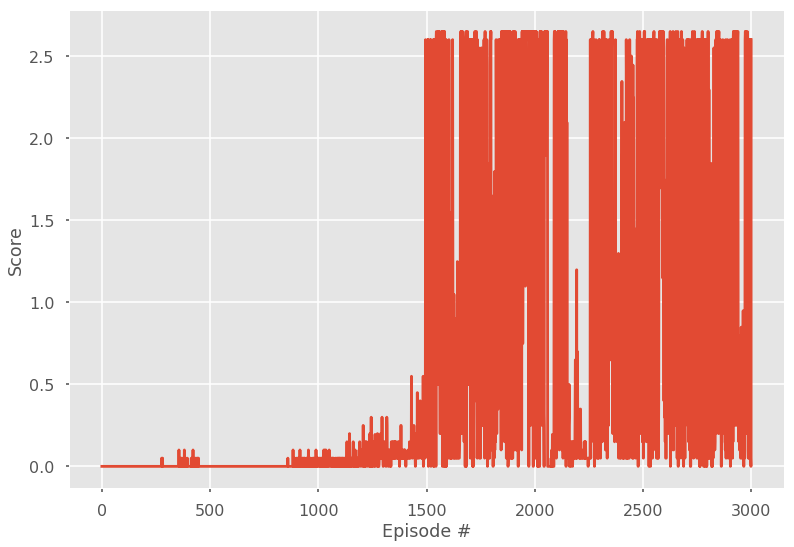

In [22]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline   
print(f"Environment First Solved on Episode #{first_solved}")
plt.style.use('seaborn-poster')
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(scores)), scores)    
plt.ylabel('Score')                                        
plt.xlabel('Episode #')   
plt.show()                                          

### Starting from the Saved Training Weights:

---

In the cells below we start off by loading the weights of the actor and critic of the agent from the saved weights. We use the Pytorch's `load_state_dict()` function in order to handle this. We will play a total of 10 episodes of the game, while keeping the environment configuration to the following:

```python 
env.reset(train_mode=False)[brain_name]
```

In [32]:
from agent import Agent
import torch
agent = Agent(state_size, action_size, random_seed=20, parallal=True, num_agents=num_agents)
agent.actor_online.load_state_dict(torch.load('weights_actor.pth'))
agent.critic_online.load_state_dict(torch.load('weights_critic.pth'))

In [ ]:
for i in range(10):                                        # play game for 5 episodes
    env_info = env.reset(train_mode=False)[brain_name]     # reset the environment    
    states = env_info.vector_observations                  # get the current state (for each agent)
    scores = np.zeros(num_agents)                          # initialize the score (for each agent)
    while True:
        actions = agent.act(state, noisy=False)            # select an action (for each agent)
        env_info = env.step(actions)[brain_name]           # send all actions to tne environment
        next_states = env_info.vector_observations         # get next state (for each agent)
        rewards = env_info.rewards                         # get reward (for each agent)
        dones = env_info.local_done                        # see if episode finished
        agent.step(states, actions, rewards, next_states, dones)
        scores += env_info.rewards                         # update the score (for each agent)
        states = next_states                               # roll over states to next time step
        if np.any(dones):                                  # exit loop if episode finished
            break
    print('Total score (averaged over agents) this episode: {}'.format(np.mean(scores)))

#### Close the Environment:
After the experimentations are over the environment can be closed.

In [ ]:
env.close()